In [1]:
import trainer
from utils import get_batch_classifier, slanted_triangular_learning_rate
import json
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
%matplotlib inline

In [2]:
with open('SentimentAnalysis/word2idx.json', 'r') as inp:
    word2idx = json.load(inp)
with open('SentimentAnalysis/char2idx.json', 'r') as inp:
    char2idx = json.load(inp)

In [3]:
VERSION = '102_sa'
params = dict(
    model_configs = {
      "rnn_layers":[
          {
             "units": 1024,
             "drop_i": 0.2,
             "wdrop": 0.4,
             "drop_o": 0.2
          },
          {
             "units": 1024,
             "wdrop": 0.4,
             "drop_o": 0.2
          },
          {
             "units": 1024,
             "drop_o": 0.2,
             "wdrop": 0.4
          }
],
       "vocab_size": len(word2idx) + 1,
       "drop_e": 0.0,
       "char_vocab_size": len(char2idx) + 1,
       "char_cnn_options": {
           "layers": [
                [1, 16],
                [2, 16],
                [3, 32],
                [4, 64],
                [5, 128],
                [6, 256],
                [7, 512]
           ],
           "n_highways": 2
       },
       "char_vec_size": 16,
       "projection_dims": 512,
       "skip_connection": True
    },
    optimizer = {'name': 'adamw', 'params': {'beta1': 0.9, 'beta2': 0.999, 'weight_decay': 0.0}},
    negative_samples = 10240,
    wdecay = 0.0,
    alpha = 1e-6,
    beta = 1e-6,
    clip_norm = 25.0,
    clip_min = -100.0, clip_max = 100.0,
    bptt = 70,
    use_ema = False,
    save_freq = 50,
    log_path = '{}/logs'.format(VERSION),
    train_summary_dir = '{}/train_summary/'.format(VERSION),
    test_summary_dir = '{}/test_summary/'.format(VERSION),
    checkpoint_dir = '{}/checkpoints/'.format(VERSION)
)

my_trainer = trainer.Trainer(**params, fine_tune=True)

my_trainer.logger.info('Trainer params {}'.format(params))

tf.reset_default_graph()

Trainer params {'model_configs': {'rnn_layers': [{'units': 1024, 'drop_i': 0.2, 'wdrop': 0.4, 'drop_o': 0.2}, {'units': 1024, 'wdrop': 0.4, 'drop_o': 0.2}, {'units': 1024, 'drop_o': 0.2, 'wdrop': 0.4}], 'vocab_size': 153531, 'drop_e': 0.0, 'char_vocab_size': 1005, 'char_cnn_options': {'layers': [[1, 16], [2, 16], [3, 32], [4, 64], [5, 128], [6, 256], [7, 512]], 'n_highways': 2}, 'char_vec_size': 16, 'projection_dims': 512, 'skip_connection': True}, 'optimizer': {'name': 'adamw', 'params': {'beta1': 0.9, 'beta2': 0.999, 'weight_decay': 0.0}}, 'negative_samples': 10240, 'wdecay': 0.0, 'alpha': 1e-06, 'beta': 1e-06, 'clip_norm': 25.0, 'clip_min': -100.0, 'clip_max': 100.0, 'bptt': 70, 'use_ema': False, 'save_freq': 50, 'log_path': '102_sa/logs', 'train_summary_dir': '102_sa/train_summary/', 'test_summary_dir': '102_sa/test_summary/', 'checkpoint_dir': '102_sa/checkpoints/'}


In [4]:
classifier_configs = {
    'layers': [
        {'batch_norm': False, 'drop_out': 0.2},
        {'units': 50, 'batch_norm': False, 'drop_out': 0.1, 'activation': 'relu'}
    ], 'n_classes': 3
}
my_trainer.build_classifier(classifier_configs, folder_name='final_classifier_train_1')

/root/anaconda2/envs/tfp/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [5]:
my_trainer.restore_language_model('102_sa/checkpoints/test_sa/model.cpkt-5440')

INFO:tensorflow:Restoring parameters from 102_sa/checkpoints/test_sa/model.cpkt-5440


Restoring parameters from 102_sa/checkpoints/test_sa/model.cpkt-5440


In [6]:
train_chars = np.load('SentimentAnalysis/class_train_char.npy')
train_labels = np.load('SentimentAnalysis/class_train_label.npy')

In [7]:
test_chars = np.load('SentimentAnalysis/class_test_char.npy')
test_labels = np.load('SentimentAnalysis/class_test_label.npy')

In [8]:
train_chars = np.array([x[:300] for x in train_chars])

In [9]:
TRAIN_FOLDER = 'final_classifier_train_1'
TEST_FOLDER = 'final_classifier_test_1'
RATIO = 1/2.6
RATIO1 = RATIO/(1+RATIO)
BATCH_SIZE = 17
BPTT = 70

In [10]:
log_lrs, losses = my_trainer.find_lr_classifier(train_chars, train_labels, BATCH_SIZE, BPTT, [0, 200], fine_tune_rate=[0, 0, 0, 0])

Batch    1,  lr 0.00000, loss 2.64390, smoothed loss 2.64390
Batch    2,  lr 0.00000, loss 2.92331, smoothed loss 2.78502
Batch    3,  lr 0.00000, loss 2.52237, smoothed loss 2.69569
Batch    4,  lr 0.00000, loss 2.37049, smoothed loss 2.61191
Batch    5,  lr 0.00000, loss 2.86789, smoothed loss 2.66520
Batch    6,  lr 0.00000, loss 1.94034, smoothed loss 2.53820
Batch    7,  lr 0.00000, loss 2.61536, smoothed loss 2.54991
Batch    8,  lr 0.00000, loss 2.69613, smoothed loss 2.56950
Batch    9,  lr 0.00000, loss 2.06511, smoothed loss 2.50883
Batch   10,  lr 0.00000, loss 2.63648, smoothed loss 2.52278
Batch   11,  lr 0.00000, loss 3.06104, smoothed loss 2.57681
Batch   12,  lr 0.00000, loss 2.37647, smoothed loss 2.55819
Batch   13,  lr 0.00000, loss 2.31545, smoothed loss 2.53718
Batch   14,  lr 0.00000, loss 2.52373, smoothed loss 2.53608
Batch   15,  lr 0.00000, loss 2.51936, smoothed loss 2.53481
Batch   16,  lr 0.00000, loss 2.26618, smoothed loss 2.51535
Batch   17,  lr 0.00000,

Batch  136,  lr 0.00011, loss 1.24404, smoothed loss 1.74779
Batch  137,  lr 0.00012, loss 1.11574, smoothed loss 1.73430
Batch  138,  lr 0.00013, loss 1.43711, smoothed loss 1.72797
Batch  139,  lr 0.00014, loss 1.20271, smoothed loss 1.71679
Batch  140,  lr 0.00015, loss 1.15001, smoothed loss 1.70474
Batch  141,  lr 0.00016, loss 1.46073, smoothed loss 1.69956
Batch  142,  lr 0.00017, loss 1.36310, smoothed loss 1.69243
Batch  143,  lr 0.00018, loss 1.22284, smoothed loss 1.68248
Batch  144,  lr 0.00019, loss 1.22298, smoothed loss 1.67276
Batch  145,  lr 0.00021, loss 1.01049, smoothed loss 1.65877
Batch  146,  lr 0.00022, loss 1.23863, smoothed loss 1.64990
Batch  147,  lr 0.00024, loss 1.17235, smoothed loss 1.63984
Batch  148,  lr 0.00026, loss 1.34270, smoothed loss 1.63358
Batch  149,  lr 0.00028, loss 0.98908, smoothed loss 1.62002
Batch  150,  lr 0.00030, loss 1.33917, smoothed loss 1.61412
Batch  151,  lr 0.00032, loss 0.97860, smoothed loss 1.60078
Batch  152,  lr 0.00034,

Batch  271,  lr 1.25893, loss 1.08317, smoothed loss 1.19080
Batch  272,  lr 1.34896, loss 1.11095, smoothed loss 1.18920
Batch  273,  lr 1.44544, loss 1.15740, smoothed loss 1.18856
Batch  274,  lr 1.54882, loss 1.06851, smoothed loss 1.18615
Batch  275,  lr 1.65959, loss 1.25429, smoothed loss 1.18751
Batch  276,  lr 1.77828, loss 1.17290, smoothed loss 1.18722
Batch  277,  lr 1.90546, loss 1.10521, smoothed loss 1.18558
Batch  278,  lr 2.04174, loss 1.21359, smoothed loss 1.18614
Batch  279,  lr 2.18776, loss 1.14943, smoothed loss 1.18540
Batch  280,  lr 2.34423, loss 1.09466, smoothed loss 1.18358
Batch  281,  lr 2.51189, loss 1.40275, smoothed loss 1.18798
Batch  282,  lr 2.69153, loss 1.03494, smoothed loss 1.18491
Batch  283,  lr 2.88403, loss 0.99542, smoothed loss 1.18110
Batch  284,  lr 3.09030, loss 1.17914, smoothed loss 1.18107
Batch  285,  lr 3.31131, loss 1.08952, smoothed loss 1.17923
Batch  286,  lr 3.54813, loss 1.06238, smoothed loss 1.17688
Batch  287,  lr 3.80189,

Restoring parameters from 102_sa/checkpoints/tmp/model.cpkt


update_title_pos
findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/root/anaconda2/envs/tfp/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
update_title_pos
update_title_pos
update_title_pos
update_title_pos


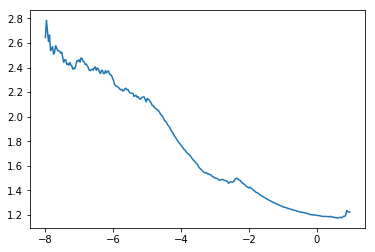

In [11]:
fig = plt.figure()
ax = plt.axes()
ax.plot(log_lrs, losses)

In [10]:
NUM_EPOCH = 15
TOTAL_ITER = NUM_EPOCH * len(train_labels)/BATCH_SIZE
LR_MAX = 5e-4
LR_RATIO = 32
lr = slanted_triangular_learning_rate(TOTAL_ITER, 1/NUM_EPOCH, LR_MAX, LR_RATIO)
for _ in range(NUM_EPOCH):
    my_trainer.train_step_classifier(train_chars, train_labels, BATCH_SIZE, lr, BPTT, [0, 200], fine_tune_rate=[RATIO, RATIO1, RATIO1, RATIO], folder_name=TRAIN_FOLDER)

Step    1: loss: 1.57966, acc: 0.47059, bptt:  69, time 04.46
Step    2: loss: 1.03279, acc: 0.52941, bptt:  38, time 04.64
Step    3: loss: 1.55927, acc: 0.35294, bptt:  65, time 05.08
Step    4: loss: 1.48733, acc: 0.29412, bptt:  67, time 05.42
Step    5: loss: 1.76286, acc: 0.41176, bptt:  73, time 05.96
Step    6: loss: 1.64958, acc: 0.23529, bptt:  67, time 06.57
Step    7: loss: 1.31944, acc: 0.23529, bptt:  72, time 06.84
Step    8: loss: 1.47177, acc: 0.29412, bptt:  67, time 07.48
Step    9: loss: 1.23529, acc: 0.35294, bptt:  62, time 07.86
Step   10: loss: 1.10299, acc: 0.47059, bptt:  68, time 08.38
Step   11: loss: 1.26307, acc: 0.29412, bptt:  66, time 08.94
Step   12: loss: 1.21562, acc: 0.41176, bptt:  72, time 09.59
Step   13: loss: 1.19827, acc: 0.35294, bptt:  69, time 09.98
Step   14: loss: 1.33488, acc: 0.29412, bptt:  66, time 10.23
Step   15: loss: 1.52082, acc: 0.23529, bptt:  66, time 10.63
Step   16: loss: 1.36149, acc: 0.35294, bptt:  64, time 11.18
Step   1

Step  134: loss: 0.67122, acc: 0.64706, bptt:  71, time 60.08
Step  135: loss: 0.56910, acc: 0.76471, bptt:  71, time 60.50
Step  136: loss: 0.64178, acc: 0.64706, bptt:  65, time 60.92
Step  137: loss: 1.01514, acc: 0.47059, bptt:  66, time 61.21
Step  138: loss: 0.85235, acc: 0.58824, bptt:  74, time 61.46
Step  139: loss: 1.02089, acc: 0.58824, bptt:  64, time 61.86
Step  140: loss: 0.97239, acc: 0.64706, bptt:  62, time 62.17
Step  141: loss: 0.50415, acc: 0.76471, bptt:  55, time 62.53
Step  142: loss: 0.99829, acc: 0.47059, bptt:  68, time 62.83
Step  143: loss: 0.73460, acc: 0.76471, bptt:  69, time 63.08
Step  144: loss: 0.82884, acc: 0.64706, bptt:  76, time 63.27
Step  145: loss: 1.00669, acc: 0.64706, bptt:  71, time 63.73
Step  146: loss: 0.90125, acc: 0.47059, bptt:  30, time 64.21
Step  147: loss: 0.48048, acc: 0.82353, bptt:  65, time 64.54
Step  148: loss: 0.77479, acc: 0.70588, bptt:  66, time 64.99
Step  149: loss: 0.81266, acc: 0.58824, bptt:  58, time 65.40
Step  15

Step  266: loss: 0.81805, acc: 0.70588, bptt:  61, time 108.79
Step  267: loss: 0.94595, acc: 0.76471, bptt:  59, time 108.99
Step  268: loss: 1.46213, acc: 0.47059, bptt:  79, time 109.41
Step  269: loss: 1.09619, acc: 0.35294, bptt:  62, time 109.69
Step  270: loss: 0.68557, acc: 0.76471, bptt:  75, time 109.95
Step  271: loss: 0.89531, acc: 0.64706, bptt:  40, time 110.33
Step  272: loss: 0.62399, acc: 0.76471, bptt:  72, time 110.61
Step  273: loss: 0.78480, acc: 0.70588, bptt:  68, time 110.86
Step  274: loss: 0.81853, acc: 0.58824, bptt:  72, time 111.29
Step  275: loss: 0.75935, acc: 0.76471, bptt:  64, time 111.82
Step  276: loss: 0.60953, acc: 0.76471, bptt:  74, time 112.01
Step  277: loss: 0.89237, acc: 0.47059, bptt:  72, time 112.41
Step  278: loss: 1.15099, acc: 0.41176, bptt:  68, time 112.87
Step  279: loss: 0.67447, acc: 0.70588, bptt:  58, time 113.05
Step  280: loss: 0.47911, acc: 0.76471, bptt:  65, time 113.30
Step  281: loss: 0.99224, acc: 0.64706, bptt:  39, time

Step  398: loss: 0.64173, acc: 0.70588, bptt:  69, time 36.22
Step  399: loss: 0.74536, acc: 0.76471, bptt:  65, time 36.73
Step  400: loss: 0.67921, acc: 0.58824, bptt:  65, time 37.19
Step  401: loss: 0.51160, acc: 0.70588, bptt:  77, time 38.83
Step  402: loss: 0.55506, acc: 0.76471, bptt:  68, time 39.20
Step  403: loss: 0.64969, acc: 0.58824, bptt:  59, time 39.75
Step  404: loss: 0.82572, acc: 0.58824, bptt:  66, time 39.99
Step  405: loss: 0.72389, acc: 0.76471, bptt:  72, time 40.18
Step  406: loss: 0.92367, acc: 0.70588, bptt:  60, time 40.57
Step  407: loss: 1.02956, acc: 0.58824, bptt:  66, time 41.05
Step  408: loss: 0.52995, acc: 0.76471, bptt:  76, time 41.45
Step  409: loss: 0.61233, acc: 0.70588, bptt:  71, time 41.69
Step  410: loss: 0.74950, acc: 0.58824, bptt:  66, time 42.04
Step  411: loss: 0.48801, acc: 0.82353, bptt:  72, time 42.56
Step  412: loss: 1.18422, acc: 0.35294, bptt:  75, time 42.89
Step  413: loss: 0.79385, acc: 0.76471, bptt:  84, time 43.30
Step  41

Step  531: loss: 0.81518, acc: 0.64706, bptt:  63, time 84.83
Step  532: loss: 0.68432, acc: 0.64706, bptt:  64, time 84.99
Step  533: loss: 0.99254, acc: 0.52941, bptt:  77, time 85.17
Step  534: loss: 0.64082, acc: 0.76471, bptt:  68, time 85.68
Step  535: loss: 0.53880, acc: 0.76471, bptt:  64, time 86.03
Step  536: loss: 0.72903, acc: 0.70588, bptt:  77, time 86.37
Step  537: loss: 0.59100, acc: 0.76471, bptt:  69, time 86.65
Step  538: loss: 0.62679, acc: 0.70588, bptt:  69, time 86.93
Step  539: loss: 0.68604, acc: 0.76471, bptt:  72, time 87.18
Step  540: loss: 0.66744, acc: 0.70588, bptt:  40, time 87.54
Step  541: loss: 0.72540, acc: 0.70588, bptt:  73, time 88.07
Step  542: loss: 0.39804, acc: 0.94118, bptt:  63, time 88.49
Step  543: loss: 0.66938, acc: 0.76471, bptt:  69, time 88.91
Step  544: loss: 0.64812, acc: 0.70588, bptt:  69, time 89.10
Step  545: loss: 0.53142, acc: 0.88235, bptt:  75, time 89.28
Step  546: loss: 0.46720, acc: 0.70588, bptt:  69, time 89.43
Step  54

Step  663: loss: 0.48950, acc: 0.76471, bptt:  68, time 21.36
Step  664: loss: 0.32828, acc: 0.82353, bptt:  64, time 21.71
Step  665: loss: 0.62505, acc: 0.88235, bptt:  67, time 22.34
Step  666: loss: 0.25909, acc: 0.88235, bptt:  72, time 22.67
Step  667: loss: 0.69179, acc: 0.76471, bptt:  76, time 22.98
Step  668: loss: 0.62009, acc: 0.70588, bptt:  72, time 23.37
Step  669: loss: 0.52730, acc: 0.64706, bptt:  69, time 23.57
Step  670: loss: 0.80595, acc: 0.58824, bptt:  68, time 23.85
Step  671: loss: 0.31473, acc: 0.94118, bptt:  70, time 24.10
Step  672: loss: 0.75896, acc: 0.70588, bptt:  76, time 24.41
Step  673: loss: 0.63805, acc: 0.82353, bptt:  73, time 24.73
Step  674: loss: 0.56976, acc: 0.76471, bptt:  65, time 25.10
Step  675: loss: 0.43883, acc: 0.76471, bptt:  69, time 25.36
Step  676: loss: 0.43437, acc: 0.76471, bptt:  68, time 25.88
Step  677: loss: 0.58129, acc: 0.70588, bptt:  73, time 26.28
Step  678: loss: 0.49948, acc: 0.82353, bptt:  62, time 26.61
Step  67

Step  796: loss: 0.59799, acc: 0.70588, bptt:  70, time 72.74
Step  797: loss: 0.64203, acc: 0.76471, bptt:  70, time 72.92
Step  798: loss: 0.48422, acc: 0.82353, bptt:  70, time 73.24
Step  799: loss: 0.64692, acc: 0.76471, bptt:  70, time 73.47
Step  800: loss: 0.44113, acc: 0.76471, bptt:  69, time 73.84
Step  801: loss: 0.64105, acc: 0.82353, bptt:  74, time 75.11
Step  802: loss: 0.51313, acc: 0.82353, bptt:  71, time 75.39
Step  803: loss: 0.72506, acc: 0.70588, bptt:  59, time 75.70
Step  804: loss: 0.82200, acc: 0.64706, bptt:  30, time 76.06
Step  805: loss: 0.30022, acc: 0.94118, bptt:  68, time 76.35
Step  806: loss: 0.84379, acc: 0.58824, bptt:  69, time 76.65
Step  807: loss: 0.92692, acc: 0.52941, bptt:  76, time 76.85
Step  808: loss: 0.85000, acc: 0.64706, bptt:  69, time 77.03
Step  809: loss: 0.41326, acc: 0.76471, bptt:  74, time 77.42
Step  810: loss: 0.50005, acc: 0.82353, bptt:  74, time 77.59
Step  811: loss: 0.67384, acc: 0.64706, bptt:  36, time 78.08
Step  81

Step  928: loss: 0.20527, acc: 0.94118, bptt:  75, time 10.75
Step  929: loss: 0.69249, acc: 0.70588, bptt:  65, time 11.25
Step  930: loss: 0.45911, acc: 0.76471, bptt:  69, time 11.40
Step  931: loss: 0.55907, acc: 0.76471, bptt:  72, time 11.65
Step  932: loss: 0.66160, acc: 0.76471, bptt:  64, time 12.09
Step  933: loss: 0.20187, acc: 0.88235, bptt:  71, time 12.25
Step  934: loss: 0.15234, acc: 0.94118, bptt:  73, time 12.50
Step  935: loss: 0.31979, acc: 0.82353, bptt:  66, time 12.74
Step  936: loss: 0.63262, acc: 0.76471, bptt:  34, time 12.93
Step  937: loss: 0.47247, acc: 0.88235, bptt:  64, time 13.29
Step  938: loss: 0.33159, acc: 0.82353, bptt:  69, time 13.47
Step  939: loss: 0.46255, acc: 0.82353, bptt:  71, time 13.82
Step  940: loss: 0.28750, acc: 0.82353, bptt:  69, time 13.99
Step  941: loss: 0.37414, acc: 0.82353, bptt:  82, time 14.50
Step  942: loss: 0.84190, acc: 0.64706, bptt:  74, time 14.70
Step  943: loss: 0.23748, acc: 0.94118, bptt:  70, time 15.21
Step  94

Step 1061: loss: 0.59783, acc: 0.70588, bptt:  81, time 56.71
Step 1062: loss: 0.37888, acc: 0.88235, bptt:  72, time 56.91
Step 1063: loss: 0.61112, acc: 0.82353, bptt:  68, time 57.19
Step 1064: loss: 0.32461, acc: 0.94118, bptt:  75, time 57.63
Step 1065: loss: 0.42930, acc: 0.88235, bptt:  78, time 57.93
Step 1066: loss: 0.49744, acc: 0.76471, bptt:  62, time 58.19
Step 1067: loss: 0.67425, acc: 0.70588, bptt:  71, time 58.39
Step 1068: loss: 0.38679, acc: 0.82353, bptt:  75, time 58.73
Step 1069: loss: 0.55962, acc: 0.82353, bptt:  72, time 59.26
Step 1070: loss: 0.30444, acc: 0.94118, bptt:  65, time 59.53
Step 1071: loss: 0.43606, acc: 0.76471, bptt:  28, time 59.87
Step 1072: loss: 0.57132, acc: 0.64706, bptt:  71, time 60.20
Step 1073: loss: 0.45529, acc: 0.88235, bptt:  66, time 60.44
Step 1074: loss: 0.66659, acc: 0.76471, bptt:  66, time 60.89
Step 1075: loss: 0.64489, acc: 0.82353, bptt:  63, time 61.30
Step 1076: loss: 0.72402, acc: 0.64706, bptt:  68, time 61.64
Step 107

Step 1193: loss: 0.72865, acc: 0.64706, bptt:  70, time 103.55
Step 1194: loss: 0.51375, acc: 0.88235, bptt:  71, time 103.86
Step 1195: loss: 0.56897, acc: 0.70588, bptt:  73, time 104.35
Step 1196: loss: 0.39645, acc: 0.82353, bptt:  58, time 104.58
Step 1197: loss: 0.46510, acc: 0.76471, bptt:  67, time 105.16
Step 1198: loss: 0.57937, acc: 0.70588, bptt:  33, time 105.69
Step 1199: loss: 0.55905, acc: 0.82353, bptt:  34, time 106.15
Step 1200: loss: 0.58499, acc: 0.64706, bptt:  71, time 106.57
Step 1201: loss: 0.36145, acc: 0.76471, bptt:  69, time 00.89
Step 1202: loss: 0.56450, acc: 0.82353, bptt:  68, time 01.73
Step 1203: loss: 0.68237, acc: 0.70588, bptt:  69, time 02.58
Step 1204: loss: 0.25245, acc: 0.94118, bptt:  65, time 02.93
Step 1205: loss: 0.34259, acc: 0.82353, bptt:  60, time 03.21
Step 1206: loss: 0.22630, acc: 0.94118, bptt:  66, time 03.47
Step 1207: loss: 0.39578, acc: 0.82353, bptt:  65, time 03.82
Step 1208: loss: 0.33627, acc: 0.82353, bptt:  65, time 04.08


Step 1326: loss: 0.28424, acc: 0.94118, bptt:  65, time 41.58
Step 1327: loss: 0.20433, acc: 0.94118, bptt:  73, time 41.94
Step 1328: loss: 0.31252, acc: 0.76471, bptt:  74, time 42.20
Step 1329: loss: 0.25097, acc: 0.94118, bptt:  32, time 42.46
Step 1330: loss: 0.26660, acc: 0.88235, bptt:  72, time 42.65
Step 1331: loss: 0.55240, acc: 0.82353, bptt:  75, time 42.92
Step 1332: loss: 0.88516, acc: 0.64706, bptt:  80, time 43.13
Step 1333: loss: 0.56326, acc: 0.70588, bptt:  76, time 43.32
Step 1334: loss: 0.19920, acc: 0.94118, bptt:  72, time 43.53
Step 1335: loss: 0.41553, acc: 0.88235, bptt:  75, time 44.06
Step 1336: loss: 0.76768, acc: 0.58824, bptt:  71, time 44.38
Step 1337: loss: 0.40593, acc: 0.76471, bptt:  42, time 44.80
Step 1338: loss: 0.16746, acc: 0.94118, bptt:  63, time 45.35
Step 1339: loss: 0.44184, acc: 0.82353, bptt:  64, time 45.61
Step 1340: loss: 0.25413, acc: 0.88235, bptt:  74, time 45.89
Step 1341: loss: 0.28018, acc: 0.94118, bptt:  70, time 46.21
Step 134

Step 1459: loss: 0.21747, acc: 0.94118, bptt:  64, time 89.62
Step 1460: loss: 0.42657, acc: 0.88235, bptt:  67, time 90.06
Step 1461: loss: 0.55340, acc: 0.76471, bptt:  67, time 90.36
Step 1462: loss: 0.48016, acc: 0.88235, bptt:  60, time 90.58
Step 1463: loss: 0.25156, acc: 0.94118, bptt:  75, time 90.77
Step 1464: loss: 0.42703, acc: 0.76471, bptt:  70, time 91.24
Step 1465: loss: 0.20484, acc: 0.94118, bptt:  65, time 91.71
Step 1466: loss: 0.40211, acc: 0.88235, bptt:  63, time 91.95
Step 1467: loss: 0.57128, acc: 0.76471, bptt:  65, time 92.38
Step 1468: loss: 0.34450, acc: 0.82353, bptt:  65, time 92.72
Step 1469: loss: 0.41912, acc: 0.70588, bptt:  74, time 93.01
Step 1470: loss: 0.22137, acc: 0.94118, bptt:  70, time 93.28
Step 1471: loss: 0.82921, acc: 0.76471, bptt:  70, time 93.75
Step 1472: loss: 0.52276, acc: 0.76471, bptt:  73, time 94.22
Step 1473: loss: 0.33489, acc: 0.82353, bptt:  70, time 94.44
Step 1474: loss: 0.23634, acc: 0.94118, bptt:  71, time 94.77
Step 147

Step 1591: loss: 0.27637, acc: 0.82353, bptt:  74, time 30.53
Step 1592: loss: 0.30941, acc: 0.82353, bptt:  77, time 30.95
Step 1593: loss: 0.47563, acc: 0.82353, bptt:  68, time 31.13
Step 1594: loss: 0.26394, acc: 0.94118, bptt:  66, time 31.56
Step 1595: loss: 0.19290, acc: 0.88235, bptt:  68, time 32.05
Step 1596: loss: 0.12610, acc: 1.00000, bptt:  66, time 32.24
Step 1597: loss: 0.14677, acc: 0.94118, bptt:  66, time 32.44
Step 1598: loss: 0.25658, acc: 0.94118, bptt:  66, time 32.58
Step 1599: loss: 0.14348, acc: 0.94118, bptt:  68, time 32.83
Step 1600: loss: 0.14254, acc: 1.00000, bptt:  64, time 33.05
Step 1601: loss: 0.20782, acc: 0.94118, bptt:  76, time 34.33
Step 1602: loss: 0.21156, acc: 0.88235, bptt:  64, time 34.59
Step 1603: loss: 0.16005, acc: 0.88235, bptt:  72, time 35.32
Step 1604: loss: 0.11222, acc: 0.94118, bptt:  74, time 35.74
Step 1605: loss: 0.23095, acc: 0.82353, bptt:  76, time 36.04
Step 1606: loss: 0.10821, acc: 1.00000, bptt:  67, time 36.21
Step 160

Step 1724: loss: 0.15415, acc: 0.94118, bptt:  68, time 75.34
Step 1725: loss: 0.16503, acc: 0.94118, bptt:  69, time 75.65
Step 1726: loss: 0.29712, acc: 0.88235, bptt:  72, time 75.80
Step 1727: loss: 0.11187, acc: 1.00000, bptt:  67, time 76.07
Step 1728: loss: 0.07284, acc: 1.00000, bptt:  70, time 76.41
Step 1729: loss: 0.08959, acc: 1.00000, bptt:  70, time 76.60
Step 1730: loss: 0.44098, acc: 0.76471, bptt:  60, time 76.86
Step 1731: loss: 0.26333, acc: 0.88235, bptt:  70, time 77.07
Step 1732: loss: 0.06675, acc: 1.00000, bptt:  69, time 77.44
Step 1733: loss: 0.13502, acc: 0.94118, bptt:  68, time 77.86
Step 1734: loss: 0.31599, acc: 0.88235, bptt:  60, time 78.32
Step 1735: loss: 0.25439, acc: 0.94118, bptt:  62, time 78.51
Step 1736: loss: 0.18659, acc: 0.94118, bptt:  68, time 78.76
Step 1737: loss: 0.36897, acc: 0.82353, bptt:  70, time 79.00
Step 1738: loss: 0.60333, acc: 0.82353, bptt:  70, time 79.54
Step 1739: loss: 0.07687, acc: 0.94118, bptt:  73, time 79.91
Step 174

Step 1857: loss: 0.08910, acc: 1.00000, bptt:  67, time 19.11
Step 1858: loss: 0.12972, acc: 0.94118, bptt:  62, time 19.28
Step 1859: loss: 0.36305, acc: 0.94118, bptt:  66, time 19.56
Step 1860: loss: 0.04170, acc: 1.00000, bptt:  66, time 19.83
Step 1861: loss: 0.26841, acc: 0.88235, bptt:  64, time 20.16
Step 1862: loss: 0.02705, acc: 1.00000, bptt:  67, time 20.67
Step 1863: loss: 0.16035, acc: 0.88235, bptt:  75, time 20.96
Step 1864: loss: 0.03602, acc: 1.00000, bptt:  65, time 21.19
Step 1865: loss: 0.07985, acc: 1.00000, bptt:  67, time 21.55
Step 1866: loss: 0.04522, acc: 1.00000, bptt:  65, time 21.99
Step 1867: loss: 0.11522, acc: 0.94118, bptt:  60, time 22.50
Step 1868: loss: 0.11883, acc: 0.94118, bptt:  66, time 22.67
Step 1869: loss: 0.09054, acc: 0.94118, bptt:  63, time 23.17
Step 1870: loss: 0.31670, acc: 0.88235, bptt:  44, time 23.48
Step 1871: loss: 0.06974, acc: 1.00000, bptt:  71, time 23.81
Step 1872: loss: 0.07395, acc: 0.94118, bptt:  73, time 24.30
Step 187

Step 1990: loss: 0.51226, acc: 0.82353, bptt:  58, time 63.50
Step 1991: loss: 0.05162, acc: 1.00000, bptt:  74, time 63.90
Step 1992: loss: 0.08665, acc: 1.00000, bptt:  73, time 64.30
Step 1993: loss: 0.57898, acc: 0.82353, bptt:  66, time 64.60
Step 1994: loss: 0.31114, acc: 0.82353, bptt:  70, time 64.80
Step 1995: loss: 0.19996, acc: 0.88235, bptt:  78, time 65.18
Step 1996: loss: 0.16497, acc: 0.94118, bptt:  70, time 65.34
Step 1997: loss: 0.16024, acc: 0.94118, bptt:  75, time 65.52
Step 1998: loss: 0.07641, acc: 1.00000, bptt:  61, time 65.71
Step 1999: loss: 0.06298, acc: 1.00000, bptt:  76, time 66.09
Step 2000: loss: 0.31317, acc: 0.88235, bptt:  61, time 66.50
Step 2001: loss: 0.41151, acc: 0.88235, bptt:  76, time 67.89
Step 2002: loss: 0.21432, acc: 0.88235, bptt:  72, time 68.13
Step 2003: loss: 0.25689, acc: 0.88235, bptt:  59, time 68.34
Step 2004: loss: 0.13511, acc: 0.94118, bptt:  73, time 68.47
Step 2005: loss: 0.10056, acc: 0.94118, bptt:  65, time 68.72
Step 200

Step 2123: loss: 0.06129, acc: 1.00000, bptt:  74, time 08.09
Step 2124: loss: 0.02707, acc: 1.00000, bptt:  68, time 08.39
Step 2125: loss: 0.01679, acc: 1.00000, bptt:  69, time 08.72
Step 2126: loss: 0.07424, acc: 0.94118, bptt:  69, time 08.90
Step 2127: loss: 0.26997, acc: 0.76471, bptt:  80, time 09.12
Step 2128: loss: 0.07597, acc: 1.00000, bptt:  73, time 09.30
Step 2129: loss: 0.13205, acc: 0.94118, bptt:  37, time 09.85
Step 2130: loss: 0.05772, acc: 1.00000, bptt:  65, time 10.14
Step 2131: loss: 0.02605, acc: 1.00000, bptt:  61, time 10.39
Step 2132: loss: 0.02780, acc: 1.00000, bptt:  75, time 10.80
Step 2133: loss: 0.05372, acc: 1.00000, bptt:  71, time 11.29
Step 2134: loss: 0.07243, acc: 0.94118, bptt:  32, time 11.56
Step 2135: loss: 0.02361, acc: 1.00000, bptt:  69, time 11.97
Step 2136: loss: 0.32298, acc: 0.88235, bptt:  69, time 12.16
Step 2137: loss: 0.25408, acc: 0.94118, bptt:  69, time 12.65
Step 2138: loss: 0.05869, acc: 1.00000, bptt:  67, time 12.90
Step 213

Step 2256: loss: 0.18655, acc: 0.94118, bptt:  65, time 52.11
Step 2257: loss: 0.37760, acc: 0.88235, bptt:  66, time 52.61
Step 2258: loss: 0.07549, acc: 1.00000, bptt:  70, time 52.79
Step 2259: loss: 0.07019, acc: 0.94118, bptt:  79, time 53.20
Step 2260: loss: 0.09636, acc: 0.94118, bptt:  72, time 53.50
Step 2261: loss: 0.22150, acc: 0.82353, bptt:  73, time 53.88
Step 2262: loss: 0.21237, acc: 0.88235, bptt:  66, time 54.20
Step 2263: loss: 0.02556, acc: 1.00000, bptt:  63, time 54.46
Step 2264: loss: 0.13899, acc: 0.94118, bptt:  70, time 54.78
Step 2265: loss: 0.08613, acc: 1.00000, bptt:  68, time 55.06
Step 2266: loss: 0.10956, acc: 1.00000, bptt:  71, time 55.60
Step 2267: loss: 0.08907, acc: 1.00000, bptt:  76, time 55.81
Step 2268: loss: 0.06939, acc: 1.00000, bptt:  63, time 56.12
Step 2269: loss: 0.09121, acc: 0.94118, bptt:  74, time 56.51
Step 2270: loss: 0.22771, acc: 0.94118, bptt:  70, time 56.71
Step 2271: loss: 0.05170, acc: 1.00000, bptt:  65, time 56.89
Step 227

Step 2389: loss: 0.09105, acc: 0.94118, bptt:  65, time 99.62
Step 2390: loss: 0.06835, acc: 1.00000, bptt:  68, time 99.98
Step 2391: loss: 0.08740, acc: 1.00000, bptt:  68, time 100.32
Step 2392: loss: 0.25471, acc: 0.82353, bptt:  65, time 100.60
Step 2393: loss: 0.31330, acc: 0.94118, bptt:  69, time 100.88
Step 2394: loss: 0.22058, acc: 0.88235, bptt:  60, time 101.29
Step 2395: loss: 0.07006, acc: 1.00000, bptt:  69, time 101.66
Step 2396: loss: 0.35296, acc: 0.88235, bptt:  58, time 101.95
Step 2397: loss: 0.06560, acc: 0.94118, bptt:  70, time 102.23
Step 2398: loss: 0.13171, acc: 0.94118, bptt:  68, time 102.67
Step 2399: loss: 0.52912, acc: 0.88235, bptt:  63, time 102.95
Step 2400: loss: 0.08863, acc: 1.00000, bptt:  70, time 103.21
Step 2401: loss: 0.03372, acc: 1.00000, bptt:  36, time 00.30
Step 2402: loss: 0.11579, acc: 0.94118, bptt:  66, time 00.82
Step 2403: loss: 0.07509, acc: 1.00000, bptt:  70, time 00.97
Step 2404: loss: 0.02898, acc: 1.00000, bptt:  76, time 01.3

Step 2521: loss: 0.01856, acc: 1.00000, bptt:  71, time 38.27
Step 2522: loss: 0.09097, acc: 0.94118, bptt:  73, time 38.62
Step 2523: loss: 0.05463, acc: 1.00000, bptt:  73, time 38.81
Step 2524: loss: 0.03914, acc: 1.00000, bptt:  67, time 39.14
Step 2525: loss: 0.10614, acc: 0.94118, bptt:  76, time 39.54
Step 2526: loss: 0.07107, acc: 1.00000, bptt:  69, time 39.91
Step 2527: loss: 0.01770, acc: 1.00000, bptt:  70, time 40.08
Step 2528: loss: 0.00769, acc: 1.00000, bptt:  61, time 40.42
Step 2529: loss: 0.06745, acc: 1.00000, bptt:  62, time 40.81
Step 2530: loss: 0.02962, acc: 1.00000, bptt:  69, time 41.28
Step 2531: loss: 0.08090, acc: 0.94118, bptt:  65, time 41.60
Step 2532: loss: 0.15487, acc: 0.88235, bptt:  35, time 41.78
Step 2533: loss: 0.05378, acc: 0.94118, bptt:  70, time 42.12
Step 2534: loss: 0.09584, acc: 0.94118, bptt:  65, time 42.65
Step 2535: loss: 0.06630, acc: 1.00000, bptt:  65, time 43.07
Step 2536: loss: 0.12769, acc: 0.94118, bptt:  76, time 43.57
Step 253

Step 2654: loss: 0.02509, acc: 1.00000, bptt:  75, time 87.36
Step 2655: loss: 0.08168, acc: 0.94118, bptt:  42, time 87.77
Step 2656: loss: 0.02068, acc: 1.00000, bptt:  71, time 88.08
Step 2657: loss: 0.01634, acc: 1.00000, bptt:  68, time 88.51
Step 2658: loss: 0.02332, acc: 1.00000, bptt:  71, time 88.79
Step 2659: loss: 0.10868, acc: 0.94118, bptt:  74, time 89.05
Step 2660: loss: 0.13308, acc: 0.88235, bptt:  71, time 89.32
Step 2661: loss: 0.34200, acc: 0.88235, bptt:  70, time 89.57
Step 2662: loss: 0.10466, acc: 0.94118, bptt:  66, time 89.80
Step 2663: loss: 0.00327, acc: 1.00000, bptt:  72, time 89.99
Step 2664: loss: 0.15777, acc: 0.94118, bptt:  76, time 90.47
Step 2665: loss: 0.04435, acc: 1.00000, bptt:  74, time 90.73
Step 2666: loss: 0.33051, acc: 0.94118, bptt:  68, time 91.20
Step 2667: loss: 0.16295, acc: 0.94118, bptt:  63, time 91.39
Step 2668: loss: 0.00291, acc: 1.00000, bptt:  65, time 91.95
Step 2669: loss: 0.01077, acc: 1.00000, bptt:  62, time 92.23
Step 267

Step 2787: loss: 0.00713, acc: 1.00000, bptt:  74, time 28.62
Step 2788: loss: 0.01199, acc: 1.00000, bptt:  73, time 28.81
Step 2789: loss: 0.05034, acc: 0.94118, bptt:  70, time 29.04
Step 2790: loss: 0.01452, acc: 1.00000, bptt:  69, time 29.19
Step 2791: loss: 0.00932, acc: 1.00000, bptt:  74, time 29.61
Step 2792: loss: 0.01000, acc: 1.00000, bptt:  42, time 30.02
Step 2793: loss: 0.00240, acc: 1.00000, bptt:  64, time 30.37
Step 2794: loss: 0.00195, acc: 1.00000, bptt:  67, time 30.53
Step 2795: loss: 0.06341, acc: 0.94118, bptt:  72, time 30.89
Step 2796: loss: 0.00746, acc: 1.00000, bptt:  70, time 31.08
Step 2797: loss: 0.01424, acc: 1.00000, bptt:  77, time 31.36
Step 2798: loss: 0.00776, acc: 1.00000, bptt:  74, time 31.81
Step 2799: loss: 0.00534, acc: 1.00000, bptt:  60, time 31.97
Step 2800: loss: 0.03462, acc: 1.00000, bptt:  73, time 32.21
Step 2801: loss: 0.03763, acc: 1.00000, bptt:  70, time 33.71
Step 2802: loss: 0.01530, acc: 1.00000, bptt:  62, time 33.85
Step 280

Step 2920: loss: 0.00435, acc: 1.00000, bptt:  72, time 72.77
Step 2921: loss: 0.00980, acc: 1.00000, bptt:  74, time 73.10
Step 2922: loss: 0.09738, acc: 0.94118, bptt:  64, time 73.45
Step 2923: loss: 0.00306, acc: 1.00000, bptt:  68, time 73.69
Step 2924: loss: 0.04694, acc: 1.00000, bptt:  68, time 74.22
Step 2925: loss: 0.00707, acc: 1.00000, bptt:  64, time 74.51
Step 2926: loss: 0.00781, acc: 1.00000, bptt:  74, time 74.97
Step 2927: loss: 0.02294, acc: 1.00000, bptt:  67, time 75.16
Step 2928: loss: 0.18818, acc: 0.94118, bptt:  74, time 75.33
Step 2929: loss: 0.00339, acc: 1.00000, bptt:  69, time 75.70
Step 2930: loss: 0.04100, acc: 1.00000, bptt:  75, time 75.97
Step 2931: loss: 0.00581, acc: 1.00000, bptt:  71, time 76.18
Step 2932: loss: 0.19741, acc: 0.94118, bptt:  73, time 76.48
Step 2933: loss: 0.01308, acc: 1.00000, bptt:  68, time 76.81
Step 2934: loss: 0.11121, acc: 0.94118, bptt:  75, time 77.01
Step 2935: loss: 0.04389, acc: 1.00000, bptt:  67, time 77.18
Step 293

Step 3053: loss: 0.00315, acc: 1.00000, bptt:  76, time 19.53
Step 3054: loss: 0.00099, acc: 1.00000, bptt:  68, time 19.79
Step 3055: loss: 0.06623, acc: 0.94118, bptt:  70, time 20.26
Step 3056: loss: 0.26068, acc: 0.94118, bptt:  73, time 20.66
Step 3057: loss: 0.00218, acc: 1.00000, bptt:  63, time 20.95
Step 3058: loss: 0.11260, acc: 0.94118, bptt:  61, time 21.40
Step 3059: loss: 0.03358, acc: 1.00000, bptt:  64, time 21.64
Step 3060: loss: 0.02555, acc: 1.00000, bptt:  67, time 21.98
Step 3061: loss: 0.00223, acc: 1.00000, bptt:  67, time 22.29
Step 3062: loss: 0.03914, acc: 1.00000, bptt:  75, time 22.80
Step 3063: loss: 0.00069, acc: 1.00000, bptt:  78, time 23.01
Step 3064: loss: 0.00547, acc: 1.00000, bptt:  72, time 23.36
Step 3065: loss: 0.03681, acc: 1.00000, bptt:  74, time 23.50
Step 3066: loss: 0.00455, acc: 1.00000, bptt:  69, time 23.66
Step 3067: loss: 0.02404, acc: 1.00000, bptt:  63, time 23.92
Step 3068: loss: 0.02081, acc: 1.00000, bptt:  70, time 24.21
Step 306

Step 3186: loss: 0.00171, acc: 1.00000, bptt:  73, time 62.92
Step 3187: loss: 0.16718, acc: 0.94118, bptt:  63, time 63.25
Step 3188: loss: 0.01068, acc: 1.00000, bptt:  71, time 63.43
Step 3189: loss: 0.00679, acc: 1.00000, bptt:  78, time 63.65
Step 3190: loss: 0.02221, acc: 1.00000, bptt:  64, time 63.91
Step 3191: loss: 0.00029, acc: 1.00000, bptt:  80, time 64.13
Step 3192: loss: 0.00405, acc: 1.00000, bptt:  62, time 64.37
Step 3193: loss: 0.04831, acc: 0.94118, bptt:  65, time 64.69
Step 3194: loss: 0.00714, acc: 1.00000, bptt:  72, time 65.04
Step 3195: loss: 0.04168, acc: 1.00000, bptt:  65, time 65.26
Step 3196: loss: 0.00091, acc: 1.00000, bptt:  71, time 65.59
Step 3197: loss: 0.00106, acc: 1.00000, bptt:  73, time 65.94
Step 3198: loss: 0.16197, acc: 0.94118, bptt:  81, time 66.27
Step 3199: loss: 0.04045, acc: 1.00000, bptt:  63, time 66.41
Step 3200: loss: 0.01576, acc: 1.00000, bptt:  67, time 66.87
Step 3201: loss: 0.00987, acc: 1.00000, bptt:  72, time 68.14
Step 320

Step 3318: loss: 0.17052, acc: 0.94118, bptt:  69, time 07.44
Step 3319: loss: 0.04737, acc: 1.00000, bptt:  70, time 07.79
Step 3320: loss: 0.00561, acc: 1.00000, bptt:  62, time 08.07
Step 3321: loss: 0.00365, acc: 1.00000, bptt:  61, time 08.54
Step 3322: loss: 0.02836, acc: 1.00000, bptt:  72, time 09.09
Step 3323: loss: 0.00498, acc: 1.00000, bptt:  66, time 09.58
Step 3324: loss: 0.03699, acc: 1.00000, bptt:  69, time 09.95
Step 3325: loss: 0.00121, acc: 1.00000, bptt:  73, time 10.13
Step 3326: loss: 0.00374, acc: 1.00000, bptt:  65, time 10.58
Step 3327: loss: 0.00049, acc: 1.00000, bptt:  75, time 10.93
Step 3328: loss: 0.00239, acc: 1.00000, bptt:  70, time 11.24
Step 3329: loss: 0.01926, acc: 1.00000, bptt:  65, time 11.46
Step 3330: loss: 0.00326, acc: 1.00000, bptt:  73, time 11.70
Step 3331: loss: 0.08538, acc: 0.94118, bptt:  67, time 11.95
Step 3332: loss: 0.00135, acc: 1.00000, bptt:  82, time 12.40
Step 3333: loss: 0.00091, acc: 1.00000, bptt:  63, time 12.67
Step 333

Step 3451: loss: 0.00026, acc: 1.00000, bptt:  67, time 52.28
Step 3452: loss: 0.00205, acc: 1.00000, bptt:  67, time 52.54
Step 3453: loss: 0.00632, acc: 1.00000, bptt:  67, time 52.89
Step 3454: loss: 0.00072, acc: 1.00000, bptt:  63, time 53.17
Step 3455: loss: 0.00077, acc: 1.00000, bptt:  73, time 53.50
Step 3456: loss: 0.00801, acc: 1.00000, bptt:  74, time 53.76
Step 3457: loss: 0.00095, acc: 1.00000, bptt:  72, time 54.16
Step 3458: loss: 0.00193, acc: 1.00000, bptt:  68, time 54.40
Step 3459: loss: 0.00304, acc: 1.00000, bptt:  62, time 54.68
Step 3460: loss: 0.01902, acc: 1.00000, bptt:  66, time 55.36
Step 3461: loss: 0.00055, acc: 1.00000, bptt:  65, time 55.63
Step 3462: loss: 0.00358, acc: 1.00000, bptt:  68, time 55.88
Step 3463: loss: 0.00123, acc: 1.00000, bptt:  74, time 56.42
Step 3464: loss: 0.00052, acc: 1.00000, bptt:  65, time 56.63
Step 3465: loss: 0.00791, acc: 1.00000, bptt:  78, time 56.98
Step 3466: loss: 0.00192, acc: 1.00000, bptt:  63, time 57.19
Step 346

Step 3584: loss: 0.00131, acc: 1.00000, bptt:  74, time 97.14
Step 3585: loss: 0.00299, acc: 1.00000, bptt:  70, time 97.34
Step 3586: loss: 0.00101, acc: 1.00000, bptt:  76, time 97.69
Step 3587: loss: 0.00727, acc: 1.00000, bptt:  65, time 97.88
Step 3588: loss: 0.01166, acc: 1.00000, bptt:  72, time 98.14
Step 3589: loss: 0.00085, acc: 1.00000, bptt:  73, time 98.65
Step 3590: loss: 0.01421, acc: 1.00000, bptt:  67, time 99.03
Step 3591: loss: 0.00607, acc: 1.00000, bptt:  32, time 99.27
Step 3592: loss: 0.00394, acc: 1.00000, bptt:  74, time 99.61
Step 3593: loss: 0.00149, acc: 1.00000, bptt:  69, time 100.07
Step 3594: loss: 0.00033, acc: 1.00000, bptt:  69, time 100.32
Step 3595: loss: 0.00656, acc: 1.00000, bptt:  67, time 100.50
Step 3596: loss: 0.01280, acc: 1.00000, bptt:  70, time 100.80
Step 3597: loss: 0.24560, acc: 0.88235, bptt:  75, time 101.07
Step 3598: loss: 0.04846, acc: 1.00000, bptt:  44, time 101.47
Step 3599: loss: 0.02555, acc: 1.00000, bptt:  61, time 101.70
S

Step 3717: loss: 0.08043, acc: 0.94118, bptt:  81, time 40.14
Step 3718: loss: 0.00451, acc: 1.00000, bptt:  67, time 40.39
Step 3719: loss: 0.00051, acc: 1.00000, bptt:  72, time 40.68
Step 3720: loss: 0.01979, acc: 1.00000, bptt:  69, time 41.12
Step 3721: loss: 0.00272, acc: 1.00000, bptt:  69, time 41.30
Step 3722: loss: 0.00095, acc: 1.00000, bptt:  63, time 41.65
Step 3723: loss: 0.00018, acc: 1.00000, bptt:  72, time 41.91
Step 3724: loss: 0.00231, acc: 1.00000, bptt:  74, time 42.37
Step 3725: loss: 0.03730, acc: 1.00000, bptt:  69, time 42.78
Step 3726: loss: 0.00048, acc: 1.00000, bptt:  78, time 43.12
Step 3727: loss: 0.00035, acc: 1.00000, bptt:  78, time 43.50
Step 3728: loss: 0.00100, acc: 1.00000, bptt:  68, time 43.70
Step 3729: loss: 0.00790, acc: 1.00000, bptt:  81, time 43.97
Step 3730: loss: 0.00193, acc: 1.00000, bptt:  80, time 44.12
Step 3731: loss: 0.02110, acc: 1.00000, bptt:  68, time 44.29
Step 3732: loss: 0.00379, acc: 1.00000, bptt:  69, time 44.71
Step 373

Step 3850: loss: 0.06666, acc: 0.94118, bptt:  73, time 86.53
Step 3851: loss: 0.00255, acc: 1.00000, bptt:  68, time 88.92
Step 3852: loss: 0.00135, acc: 1.00000, bptt:  73, time 89.36
Step 3853: loss: 0.00151, acc: 1.00000, bptt:  70, time 89.63
Step 3854: loss: 0.00525, acc: 1.00000, bptt:  70, time 89.93
Step 3855: loss: 0.00014, acc: 1.00000, bptt:  76, time 90.19
Step 3856: loss: 0.01367, acc: 1.00000, bptt:  70, time 90.65
Step 3857: loss: 0.00021, acc: 1.00000, bptt:  61, time 90.82
Step 3858: loss: 0.00091, acc: 1.00000, bptt:  67, time 91.14
Step 3859: loss: 0.00349, acc: 1.00000, bptt:  71, time 91.44
Step 3860: loss: 0.12898, acc: 0.94118, bptt:  70, time 91.76
Step 3861: loss: 0.00330, acc: 1.00000, bptt:  65, time 92.10
Step 3862: loss: 0.00087, acc: 1.00000, bptt:  33, time 92.28
Step 3863: loss: 0.01062, acc: 1.00000, bptt:  64, time 92.48
Step 3864: loss: 0.00324, acc: 1.00000, bptt:  63, time 92.80
Step 3865: loss: 0.00226, acc: 1.00000, bptt:  73, time 92.97
Step 386

Step 3982: loss: 0.00418, acc: 1.00000, bptt:  31, time 27.68
Step 3983: loss: 0.00183, acc: 1.00000, bptt:  69, time 28.14
Step 3984: loss: 0.00143, acc: 1.00000, bptt:  66, time 28.66
Step 3985: loss: 0.00197, acc: 1.00000, bptt:  68, time 29.11
Step 3986: loss: 0.00233, acc: 1.00000, bptt:  72, time 29.27
Step 3987: loss: 0.00078, acc: 1.00000, bptt:  39, time 29.44
Step 3988: loss: 0.00150, acc: 1.00000, bptt:  70, time 29.75
Step 3989: loss: 0.00054, acc: 1.00000, bptt:  71, time 29.96
Step 3990: loss: 0.00082, acc: 1.00000, bptt:  70, time 30.21
Step 3991: loss: 0.00167, acc: 1.00000, bptt:  71, time 30.52
Step 3992: loss: 0.00338, acc: 1.00000, bptt:  68, time 30.77
Step 3993: loss: 0.00462, acc: 1.00000, bptt:  68, time 31.06
Step 3994: loss: 0.00048, acc: 1.00000, bptt:  63, time 31.40
Step 3995: loss: 0.00071, acc: 1.00000, bptt:  74, time 31.56
Step 3996: loss: 0.00008, acc: 1.00000, bptt:  69, time 31.82
Step 3997: loss: 0.02448, acc: 1.00000, bptt:  80, time 32.31
Step 399

Step 4115: loss: 0.00197, acc: 1.00000, bptt:  65, time 74.58
Step 4116: loss: 0.00079, acc: 1.00000, bptt:  64, time 74.94
Step 4117: loss: 0.00065, acc: 1.00000, bptt:  71, time 75.19
Step 4118: loss: 0.00063, acc: 1.00000, bptt:  70, time 75.37
Step 4119: loss: 0.00061, acc: 1.00000, bptt:  70, time 75.61
Step 4120: loss: 0.00046, acc: 1.00000, bptt:  72, time 75.86
Step 4121: loss: 0.00318, acc: 1.00000, bptt:  65, time 76.08
Step 4122: loss: 0.00339, acc: 1.00000, bptt:  69, time 76.33
Step 4123: loss: 0.01015, acc: 1.00000, bptt:  62, time 76.73
Step 4124: loss: 0.00116, acc: 1.00000, bptt:  64, time 77.07
Step 4125: loss: 0.00149, acc: 1.00000, bptt:  65, time 77.61
Step 4126: loss: 0.00011, acc: 1.00000, bptt:  72, time 77.86
Step 4127: loss: 0.00081, acc: 1.00000, bptt:  67, time 78.36
Step 4128: loss: 0.00032, acc: 1.00000, bptt:  64, time 78.63
Step 4129: loss: 0.00905, acc: 1.00000, bptt:  68, time 79.08
Step 4130: loss: 0.00620, acc: 1.00000, bptt:  69, time 79.40
Step 413

Step 4247: loss: 0.00138, acc: 1.00000, bptt:  64, time 16.22
Step 4248: loss: 0.00077, acc: 1.00000, bptt:  72, time 16.54
Step 4249: loss: 0.00270, acc: 1.00000, bptt:  65, time 16.76
Step 4250: loss: 0.00118, acc: 1.00000, bptt:  71, time 17.13
Step 4251: loss: 0.00175, acc: 1.00000, bptt:  29, time 18.49
Step 4252: loss: 0.00656, acc: 1.00000, bptt:  70, time 18.67
Step 4253: loss: 0.00036, acc: 1.00000, bptt:  69, time 19.02
Step 4254: loss: 0.00085, acc: 1.00000, bptt:  63, time 19.32
Step 4255: loss: 0.00059, acc: 1.00000, bptt:  69, time 19.84
Step 4256: loss: 0.00034, acc: 1.00000, bptt:  34, time 20.10
Step 4257: loss: 0.00027, acc: 1.00000, bptt:  68, time 20.25
Step 4258: loss: 0.00013, acc: 1.00000, bptt:  71, time 20.52
Step 4259: loss: 0.00344, acc: 1.00000, bptt:  64, time 20.84
Step 4260: loss: 0.00045, acc: 1.00000, bptt:  72, time 21.16
Step 4261: loss: 0.00069, acc: 1.00000, bptt:  28, time 21.59
Step 4262: loss: 0.00162, acc: 1.00000, bptt:  73, time 21.83
Step 426

Step 4380: loss: 0.00023, acc: 1.00000, bptt:  78, time 64.62
Step 4381: loss: 0.00018, acc: 1.00000, bptt:  72, time 64.77
Step 4382: loss: 0.00483, acc: 1.00000, bptt:  62, time 65.32
Step 4383: loss: 0.00050, acc: 1.00000, bptt:  79, time 65.52
Step 4384: loss: 0.00014, acc: 1.00000, bptt:  75, time 65.92
Step 4385: loss: 0.00079, acc: 1.00000, bptt:  71, time 66.24
Step 4386: loss: 0.00012, acc: 1.00000, bptt:  76, time 66.61
Step 4387: loss: 0.00085, acc: 1.00000, bptt:  69, time 66.88
Step 4388: loss: 0.00007, acc: 1.00000, bptt:  73, time 67.43
Step 4389: loss: 0.00011, acc: 1.00000, bptt:  69, time 67.69
Step 4390: loss: 0.00039, acc: 1.00000, bptt:  66, time 68.19
Step 4391: loss: 0.00012, acc: 1.00000, bptt:  68, time 68.36
Step 4392: loss: 0.00249, acc: 1.00000, bptt:  68, time 68.63
Step 4393: loss: 0.00098, acc: 1.00000, bptt:  76, time 69.01
Step 4394: loss: 0.00278, acc: 1.00000, bptt:  62, time 69.44
Step 4395: loss: 0.00084, acc: 1.00000, bptt:  75, time 69.63
Step 439

In [11]:
from sklearn.metrics import classification_report

In [12]:
def eval_step_classifier(self, test_char, test_labels, batch_size, bptt, splits, folder_name='class_test'):
    import time
    import os
    start_time = time.time()
    save_path = os.path.join(self.checkpoint_dir, folder_name, 'model.cpkt')
    self.test_saver.save(self.session, save_path, global_step=self.session.run(self.global_step))
    total_loss = 0
    total_acc = 0
    count = 0
    predicts = []
    y_true = []
    for char_inputs, seq_lens, char_lens, true_labels in get_batch_classifier(test_char, test_labels, batch_size, splits, is_training=False):
        fd = {
            self.model_test.inputs: char_inputs, self.model_test.seq_lens: seq_lens,
            self.model_test.char_lens: char_lens, self.model_test.bptt: bptt,
            self.true_y: true_labels
        }
        y_pred, test_loss, test_acc = self.session.run([self.test_classifier.logits, self.test_loss, self.test_acc], feed_dict=fd)
        total_loss += test_loss * len(true_labels)
        total_acc += test_acc * len(true_labels)
        count += len(true_labels)
        predicts.append(y_pred)
        y_true.append(true_labels)
        print("Evaluate total loss: {:05.5f}, total acc: {:05.5f}, time {:05.2f}".format(total_loss/count, total_acc/count, time.time()-start_time))
    print(count)
    print(total_acc)
    return np.argmax(np.concatenate(predicts), axis=-1), np.concatenate(y_true)

In [13]:
y_pred, y_true = eval_step_classifier(my_trainer, test_chars, test_labels, 10, 20, [0, 50, 200], TEST_FOLDER)

Evaluate total loss: 3.15718, total acc: 0.50000, time 02.48
Evaluate total loss: 2.57078, total acc: 0.60000, time 02.77
Evaluate total loss: 2.59596, total acc: 0.60000, time 03.06
Evaluate total loss: 2.18765, total acc: 0.65000, time 03.24
Evaluate total loss: 1.81461, total acc: 0.70000, time 03.44
Evaluate total loss: 1.82186, total acc: 0.70000, time 03.64
Evaluate total loss: 1.86481, total acc: 0.68571, time 03.87
Evaluate total loss: 1.87170, total acc: 0.70000, time 04.03
Evaluate total loss: 1.80633, total acc: 0.68889, time 04.20
Evaluate total loss: 1.86230, total acc: 0.69000, time 04.49
Evaluate total loss: 1.88923, total acc: 0.69091, time 04.72
Evaluate total loss: 2.01660, total acc: 0.68333, time 04.90
Evaluate total loss: 2.08717, total acc: 0.67692, time 05.19
Evaluate total loss: 2.00813, total acc: 0.67857, time 05.39
Evaluate total loss: 2.15718, total acc: 0.66000, time 05.64
Evaluate total loss: 2.14547, total acc: 0.65625, time 05.80
Evaluate total loss: 2.2

In [14]:
print(classification_report(y_true=y_true, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.70      0.70      0.70       350
           1       0.65      0.65      0.65       350
           2       0.76      0.75      0.75       350

   micro avg       0.70      0.70      0.70      1050
   macro avg       0.70      0.70      0.70      1050
weighted avg       0.70      0.70      0.70      1050

